# Genres analysis

This notebook will analyze the evolution of genres in movies over the years and over the countries.

In [8]:
# Modules to import
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json

In [9]:
# Paths to add
paths = ['../data','../scripts','../utils']
for path in paths:
    sys.path.append(path)
    
# Data loader
from dataLoader import loadDataframe

# Load data
path_to_directory = '../../data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)

c:\Users\arnau\OneDrive\Documents\Scolarité EPFL\ADA\ada-2024-project-teamcsx24\src\data\dataLoader.py:10: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Modification of country names to match with geopandas name

In [10]:
df_movies.head(2)

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",[/m/09c7w0],[/m/02h40lc],"[/m/02n4kr, /m/03bxz7, /m/07s9rl0, /m/0hj3n01]"


In [11]:
# Load dictionary
path_to_directory = '../../data/freebaseIdDictionnaries'

with open(path_to_directory + '/countries_geo', 'r') as file:
    countries_dict = json.load(file)

In [12]:
def transform_country(countries_freebase_id):
    n = len(countries_freebase_id)
    for i in range(n):
        country_freebase_id = countries_freebase_id[i]
        return countries_dict[country_freebase_id]
        
df_movies['country'] = df_movies['countries_freebase_id'].apply(transform_country)

Preparation of the dataset for the analysis (explode genres and countries)

In [13]:
df_genres_countries_exploded = df_movies.explode('genres').explode('countries')
df_genres_countries_exploded.head(3)

,wiki_id,freebase_id,original_title,release_date,revenue,runtime,languages,countries,genres,countries_freebase_id,languages_freebase_id,genres_freebase_id,country
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Thriller,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",United States of America
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Science Fiction,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",United States of America
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],United States of America,Horror,[/m/09c7w0],[/m/02h40lc],"[/m/01jfsb, /m/06n90, /m/03npn, /m/03k9fj, /m/...",United States of America


In [14]:
print("Number of unique genres: ", df_genres_countries_exploded['genres'].nunique())
print(df_genres_countries_exploded['genres'].unique())

Number of unique genres:  363
['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' 'Animation' "Children's/Family" "Children's Fantasy"
 nan 'Future noir' 'Comedy film' 'Coming of age' 'Suspense'
 'Crime Thriller' 'Black comedy' 'Bollywood' 'Marriage Drama' 'Wuxia'
 'Martial Arts Film' 'Chinese Movies' 'Western' 'Parody' 'Mockumentary'
 'Fan film' 'Cult' 'Adventure Comedy' 'Slapstick' 'Biopic [feature]'
 'Historical Epic' 'Sports' 'Family Drama' 'Political drama'
 'Historical fiction' 'Courtroom Drama' 'Culture & Society' 'Biography'
 'Docume

There are 363 different genres in the dataset. The most common genres are Drama, Comedy and Romance. To begin with, we will analyze the evolution of the most common genres over years and countries.

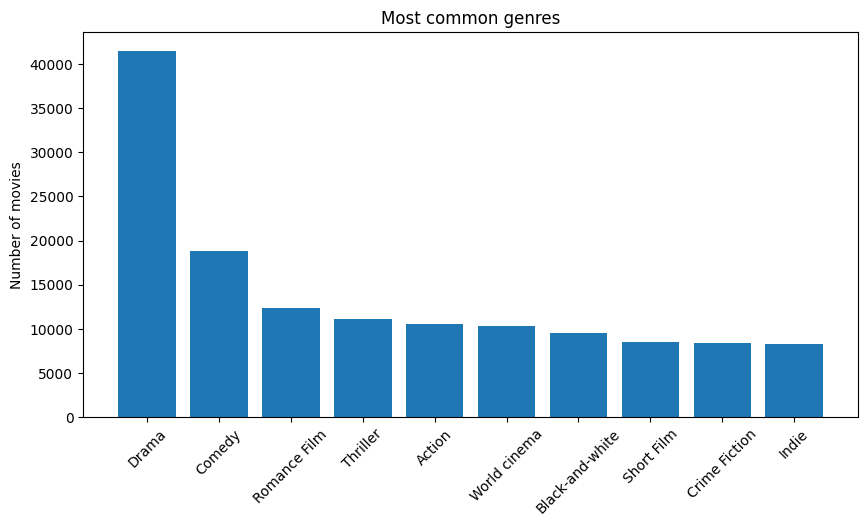

In [15]:
most_common_genres = df_genres_countries_exploded['genres'].value_counts().head(10)

plt.figure(figsize=(10,5))
plt.bar(most_common_genres.index, most_common_genres.values)
plt.title('Most common genres')
plt.ylabel('Number of movies')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Convert release date to year
df_genres_countries_exploded['year'] = pd.to_datetime(df_genres_countries_exploded['release_date']).dt.year

### 1. Analysis

In [17]:
df = df_genres_countries_exploded.groupby(['country', 'year', 'genres']).size().reset_index(name='count')
df.head(3)

,country,year,genres,count
0,Afghanistan,1975.0,Action/Adventure,2
1,Afghanistan,1975.0,Bollywood,2
2,Afghanistan,1975.0,Thriller,2


In [18]:
# Step 1: Generate all years for each country and genre
all_years = np.arange(df['year'].min(), df['year'].max() + 1)
countries = df['country'].unique()
genres = df['genres'].unique()

# Create the full grid
full_grid = pd.MultiIndex.from_product(
    [countries, all_years, genres], names=["country", "year", "genres"]
)
df_full = pd.DataFrame(index=full_grid).reset_index()

# Merge with the original data and fill NaN with 0
df_full = df_full.merge(df, on=["country", "year", "genres"], how="left").fillna(0)

# Step 2: Calculate proportions
df_full['total_count'] = df_full.groupby(['country', 'year'])['count'].transform('sum')
df_full['proportion'] = df_full['count'] / df_full['total_count']

In [19]:
# Check if for one country and year the sum of proportions is 1
df_full.groupby(['country', 'year'])['proportion'].sum().unique()

array([0., 1., 1.])

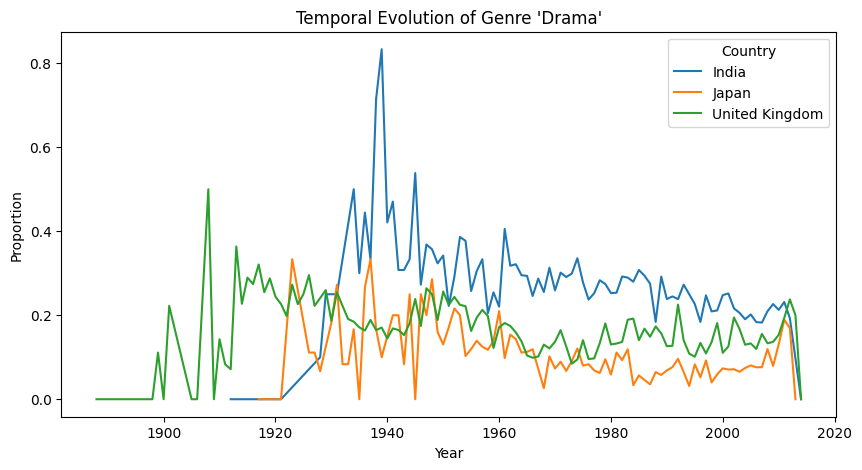

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Evolution over time for a specific genre
genre_to_plot = "Drama"
country_to_plot = ["United States", "United Kingdom", "Japan", "India"]
df_genre = df_full[df_full['genres'] == genre_to_plot]
df_genre = df_genre[df_genre['country'].isin(country_to_plot)]

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_genre, x="year", y="proportion", hue="country")
plt.title(f"Temporal Evolution of Genre '{genre_to_plot}'")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend(title="Country")
plt.show()

In [26]:
import plotly.express as px

# Example: Map for a specific genre
genre_to_map = "Drama"
df_map = df_full[df_full['genres'] == genre_to_map]

fig = px.choropleth(
    df_map,
    locations="country",
    locationmode="country names",
    color="proportion",
    hover_name="country",
    animation_frame="year",
    title=f"Evolution of Genre '{genre_to_map}' Proportion Over Time",
    color_continuous_scale="Viridis",
)
fig.show()

In [31]:
# Exemple de genre à suivre
genre_to_map = "Drama"

# Filtrer le dataframe pour le genre sélectionné
df_map = df_full[df_full['genres'] == genre_to_map]

# Étape 1 : Créer un indicateur binaire pour la présence (1 si un pays a produit ce genre cette année, sinon 0)
df_map['binary_presence'] = df_map['count'].apply(lambda x: 1 if x > 0 else 0)

# Étape 2 : Grouper par année et pays pour s'assurer de la présence/absence
df_map = df_map.groupby(['year', 'country'])['binary_presence'].max().reset_index()

# Étape 3 : Créer une liste complète des pays et des années
all_countries = df_full['country'].unique()  # Tous les pays dans le dataset
all_years = df_map['year'].unique()  # Toutes les années disponibles dans le dataset

# Créer la grille complète des pays et années (avec la présence de genre)
full_grid = pd.MultiIndex.from_product([all_years, all_countries], names=["year", "country"])

# Créer un DataFrame avec cette grille complète
df_full_grid = pd.DataFrame(index=full_grid).reset_index()

# Étape 4 : Fusionner avec les données binaires de présence et remplir les valeurs manquantes avec 0 (pays sans films du genre)
df_map = df_full_grid.merge(df_map, on=["year", "country"], how="left").fillna({'binary_presence': 0})

# Étape 5 : Suivi de la présence sur le temps (si un pays a produit un film de ce genre, il reste 1)
df_map['binary_presence'] = df_map.groupby('country')['binary_presence'].transform(lambda x: x.cummax())

# Étape 6 : Créer la carte animée de choroplèthes montrant la présence (0 ou 1)
fig = px.choropleth(
    df_map,
    locations="country",  # Noms des pays
    locationmode="country names",  # Utiliser les noms des pays pour les localisations
    color="binary_presence",  # Couleur des pays en fonction de la présence (1) ou absence (0)
    hover_name="country",  # Infos au survol montrent le pays
    animation_frame="year",  # Animer par année
    title=f"Propagation du Genre '{genre_to_map}' Au Fil du Temps (Présence ou Absence)",
    color_continuous_scale="Viridis",  # Palette de couleurs pour la présence
    range_color=[0, 1],  # Plage binaire (0 pour absence, 1 pour présence)
)

# Afficher la carte
fig.show()

C:\Users\arnau\AppData\Local\Temp\ipykernel_8556\2815381407.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

